In [29]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")

+ classify Reuters newswires into 6 mutually exclusive topics
+ instance of single-label multiclass classification. If each data point could belong to multiple categories (in this case, topics), we’d be facing a multilabel multiclass classification problem.

## Reuters dataset

+ set of short newswires and their topics, published by Reuters in 1986

In [30]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [31]:
len(train_data), type(train_data), type(train_data[0]), len(train_data[0])

(8982, numpy.ndarray, list, 87)

In [32]:
len(test_data), type(test_data), type(test_data[0]), len(test_data[0])

(2246, numpy.ndarray, list, 145)

## Decode it back to words

In [33]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [34]:
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in     train_data[0]])

In [35]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'



The label associated with an example is an integer between 0 and 45—a topic index:


In [36]:
train_labels[10]

3

## Preparing the data
You can’t directly feed lists of integers into a neural network. They all have different lengths, but a neural network expects to process contiguous batches of data. You have to turn your lists into tensors. There are two ways to do that:

+ Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, max_length), and start your model with a layer capable of handling such integer tensors (the Embedding layer, which we’ll cover in detail later in the book).
 
+ Multi-hot encode your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [8, 5] into a 10,000-dimensional vector that would be all 0s except for indices 8 and 5, which would be 1s. Then you could use a Dense layer, capable of handling floating-point vector data, as the first layer in your model.

Let’s go with the latter solution to vectorize the data, which you’ll do manually for maximum clarity.


In [37]:
def vectorize_sequences(sequences, dimension=10000): 
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results


In [38]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: you can cast the label list as an integer tensor, or you can use one-hot encoding. One-hot encoding is a widely used format for categorical data, also called categorical encoding. In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index. The following listing shows an example.

In [39]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1. 
    return results

In [40]:
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras:

In [41]:
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

## Building your model

In a stack of Dense layers like those we’ve been using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an information bottleneck. In the previous example, we used 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information.

For this reason we’ll use larger layers. Let’s go with 64 units.

In [42]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

Note

+ output is softmax of size 46. This is for 46 classes
+ softmax was introduced with MNIST. This means the output will be probability.
+ best loss function for this is categorical_crossentropy


### Compile the model

In [43]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Validating set

In [44]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

### Train

In [45]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 22ms/step - loss: 2.8363 - accuracy: 0.5008 - val_loss: 1.9412 - val_accuracy: 0.6140
Epoch 2/20
16/16 [==============================] - 0s 14ms/step - loss: 1.5956 - accuracy: 0.6790 - val_loss: 1.4126 - val_accuracy: 0.6830
Epoch 3/20
16/16 [==============================] - 0s 13ms/step - loss: 1.2068 - accuracy: 0.7261 - val_loss: 1.2189 - val_accuracy: 0.7180
Epoch 4/20
16/16 [==============================] - 0s 14ms/step - loss: 0.9929 - accuracy: 0.7840 - val_loss: 1.1063 - val_accuracy: 0.7530
Epoch 5/20
16/16 [==============================] - 0s 14ms/step - loss: 0.8244 - accuracy: 0.8231 - val_loss: 1.0143 - val_accuracy: 0.7960
Epoch 6/20
16/16 [==============================] - 0s 14ms/step - loss: 0.6890 - accuracy: 0.8548 - val_loss: 0.9589 - val_accuracy: 0.8050
Epoch 7/20
16/16 [==============================] - 0s 14ms/step - loss: 0.5771 - accuracy: 0.8792 - val_loss: 0.9214 - val_accuracy: 0.8080
Epoch 8/20
16

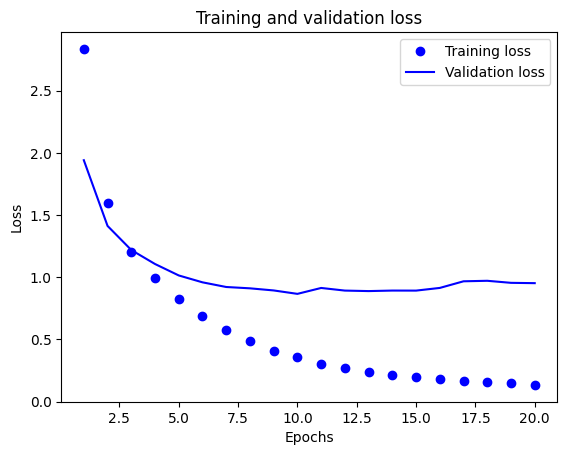

In [46]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

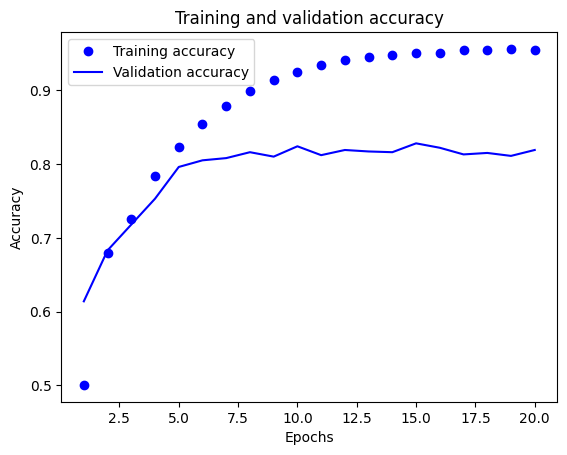

In [47]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



The model begins to overfit after nine epochs. Let’s train a new model from scratch for nine epochs and then evaluate it on the test set.


In [48]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 0s 11ms/step - loss: 2.7224 - accuracy: 0.5200
Epoch 2/9
18/18 [==============================] - 0s 11ms/step - loss: 1.5333 - accuracy: 0.6840
Epoch 3/9
18/18 [==============================] - 0s 11ms/step - loss: 1.1605 - accuracy: 0.7478
Epoch 4/9
18/18 [==============================] - 0s 11ms/step - loss: 0.9465 - accuracy: 0.7967
Epoch 5/9
18/18 [==============================] - 0s 11ms/step - loss: 0.7795 - accuracy: 0.8331
Epoch 6/9
18/18 [==============================] - 0s 12ms/step - loss: 0.6481 - accuracy: 0.8604
Epoch 7/9
18/18 [==============================] - 0s 12ms/step - loss: 0.5435 - accuracy: 0.8852
Epoch 8/9
18/18 [==============================] - 0s 11ms/step - loss: 0.4586 - accuracy: 0.9021
Epoch 9/9
71/71 [==============================] - 0s 1ms/step - loss: 0.9170 - accuracy: 0.7912


In [49]:
results

[0.9169841408729553, 0.7911843061447144]

### accuracy of a random classifier

In [50]:
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.1918967052537845

## Generating predictions on new data

In [51]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 1ms/step


In [52]:
predictions.shape

(2246, 46)

In [53]:
np.argmax(predictions,axis=1)

array([ 3, 10,  1, ...,  3,  4,  1], dtype=int64)

## A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like this:

In [54]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

The only thing this approach would change is the choice of the loss function. The loss function used in listing 4.21, categorical_crossentropy, expects the labels to follow a categorical encoding. With integer labels, you should use sparse_categorical_ crossentropy

In [55]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

|This new loss function is still mathematically the same as categorical_crossentropy; it just has a different interface. 

##  The importance of having sufficiently large intermediate layers

We mentioned earlier that because the final outputs are 46-dimensional, you should avoid intermediate layers with many fewer than 46 units. Now let’s see what happens when we introduce an information bottleneck by having intermediate layers that are significantly less than 46-dimensional: for example, 4-dimensional.

In [56]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 3.0235 - accuracy: 0.4449 - val_loss: 2.3277 - val_accuracy: 0.5180
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 1.9296 - accuracy: 0.5547 - val_loss: 1.7346 - val_accuracy: 0.5640
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1.5460 - accuracy: 0.5983 - val_loss: 1.5860 - val_accuracy: 0.5990
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 1.3724 - accuracy: 0.6369 - val_loss: 1.4995 - val_accuracy: 0.6180
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 1.2586 - accuracy: 0.6708 - val_loss: 1.4654 - val_accuracy: 0.6430
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 1.1714 - accuracy: 0.7061 - val_loss: 1.4477 - val_accuracy: 0.6630
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 1.1033 - accuracy: 0.7142 - val_loss: 1.4389 - val_accuracy: 0.6630
Epoch 8/20
63/63 [==

This does worse.

## Further experiments

Like in the previous example, I encourage you to try out the following experiments to train your intuition about the kind of configuration decisions you have to make with such models:

+ Try using larger or smaller layers: 32 units, 128 units, and so on.
+ You used two intermediate layers before the final softmax classification layer. Now try using a single intermediate layer, or three intermediate layers.


## Wrapping up

Here’s what you should take away from this example:

+ If you’re trying to classify data points among N classes, your model should end with a Dense layer of size N.
+ In a single-label, multiclass classification problem, your model should end with a softmax activation so that it will output a probability distribution over the N output classes.
+ Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the model and the true distribution of the targets.
+ There are two ways to handle labels in multiclass classification:
  + Encoding the labels via categorical encoding (also known as one-hot encoding) and using categorical_crossentropy as a loss function
  + Encoding the labels as integers and using the sparse_categorical_crossentropy loss function
+ If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your model due to intermediate layers that are too small. 
